# Version information

In [1]:
# RUN THIS FROM 'py39a' CONDA ENVIRONMENT!
%matplotlib notebook
from PySide2.QtWidgets import *
from datetime import date
print("Running date: ", date.today().strftime("%B %d, %Y"))
# Add cloned repo to system path to avoid having to pip-install as well
import sys
sys.path.append("C:/Users/nmb48/Documents/GitHub/pyleecan")  # Adjust path as needed
import pyleecan
print("Pyleecan version: " + pyleecan.__version__)
import SciDataTool
print("SciDataTool version: " + SciDataTool.__version__)

Running date:  March 13, 2025
Pyleecan version: 1.5.2
SciDataTool version: 2.5.0


## Start the GUI

In [2]:
%run -m pyleecan

## Stator definition

In [3]:
%matplotlib inline
from pyleecan.Classes.LamSlotWind import LamSlotWind

mm = 1e-3  # Millimeter

# Lamination setup
stator = LamSlotWind(
    Rint=105 * mm, # internal radius [m]
    Rext=128 * mm, # external radius [m]
    L1=198 * mm, # Lamination stack active length [m] without radial ventilation airducts 
                # but including insulation layers between lamination sheets
    Kf1=0.207, # Lamination stacking / packing factor
    is_internal=True,
    is_stator=True, 
)

### Slot definition

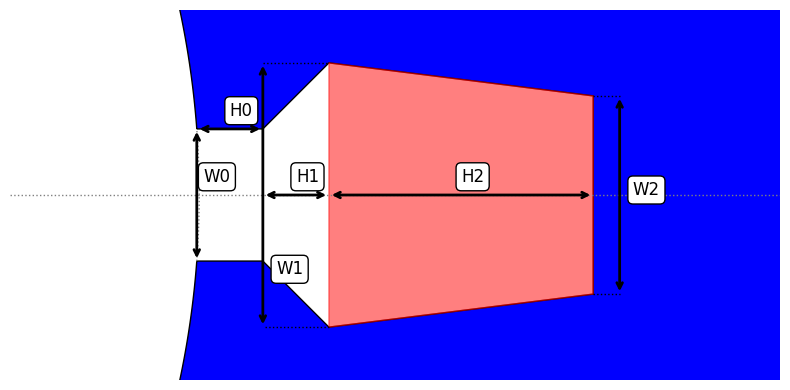

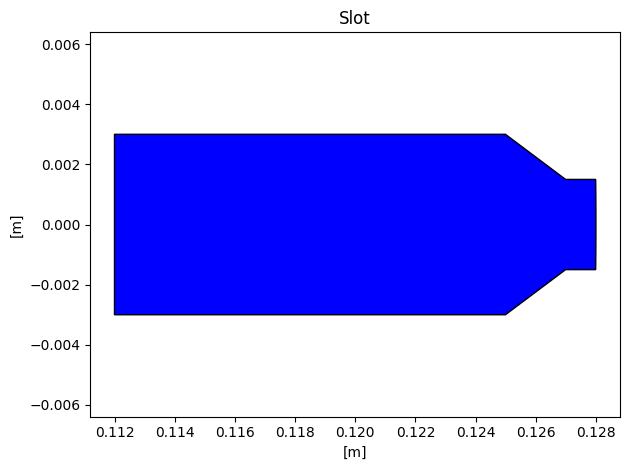

In [4]:
from pyleecan.Classes.SlotW21 import SlotW21

# Slot setup
stator.slot = SlotW21(
    Zs=60, # Slot number
    H0=1 * mm,  # Slot isthmus height
    H1=2 * mm, # Height
    H2=13 * mm, # Slot height below wedge 
    W0=3 * mm,  # Slot isthmus width
    W1=6 * mm, # Slot top width
    W2=6 * mm, # Slot bottom width
    is_bore= True,
    wedge_mat= None,
    H1_is_rad=False
)

fig, ax = stator.slot.plot_schematics(is_default=True, is_show_fig=False)
fig, ax = stator.slot.plot(is_show_fig=False)

### Define winding

C:\Users/nmb48/Documents/GitHub/pyleecan\pyleecan\Methods\Machine\LamSlotWind\plot.py:426: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


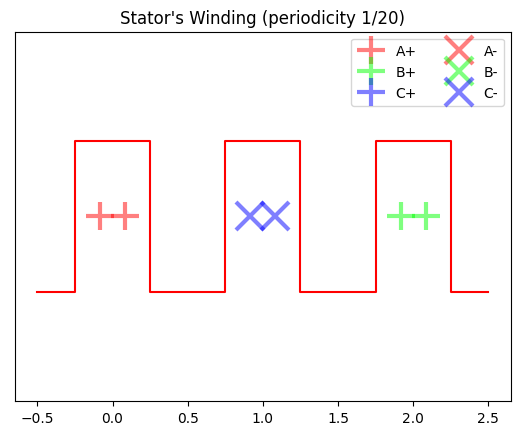

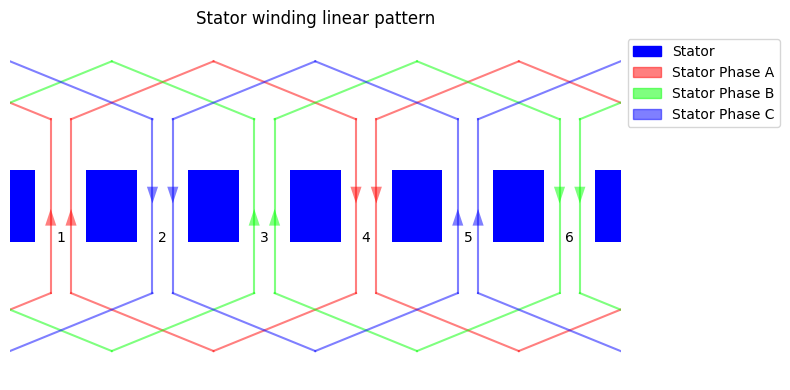

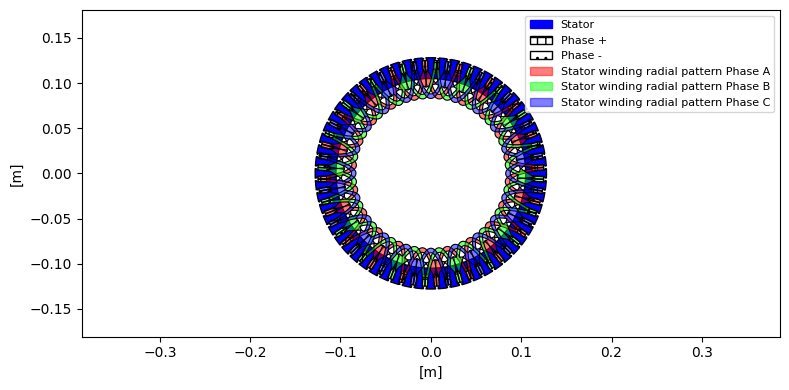

In [5]:
from pyleecan.Classes.Winding import Winding

# Winding setup
stator.winding = Winding(
    qs=3,  # number of phases
    p=10,  # number of pole pairs
    per_a= 20,
    Nlayer=2,  # Number of layers per slots
    is_change_layer=True, # corresponds to 'Double Layer non-overlapping' in GUI
    is_aper_a=True,
    
    coil_pitch=3, # Coil pitch (or coil span or Throw)
    Ntcoil=5,  # number of turns per coil
    Npcp=10,  # number of parallel circuits per phase
    Nslot_shift_wind=0,  # 0 not to change the stator winding connection matrix built by pyleecan number 
                         # of slots to shift the coils obtained with pyleecan winding algorithm 
                         # (a, b, c becomes b, c, a with Nslot_shift_wind1=1)
    is_reverse_wind=False, # True to reverse the default winding algorithm along the airgap 
                         # (c, b, a instead of a, b, c along the trigonometric direction)
    Lewout=24 * mm
)

fig, ax = stator.plot_winding(is_show_fig=False)   # Show winding pattern smallest sym
fig, ax = stator.winding.plot_linear(is_show_fig=False)
fig, ax = stator.plot(
                is_winding_connection=True,
                is_show_fig=True,
                is_add_sign=True,
            )

### Define conductor

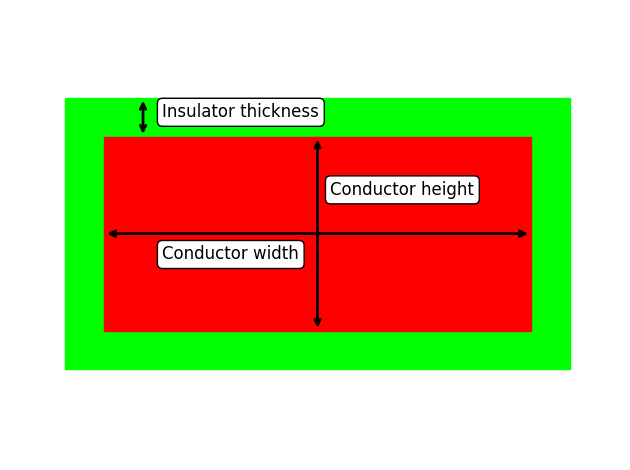

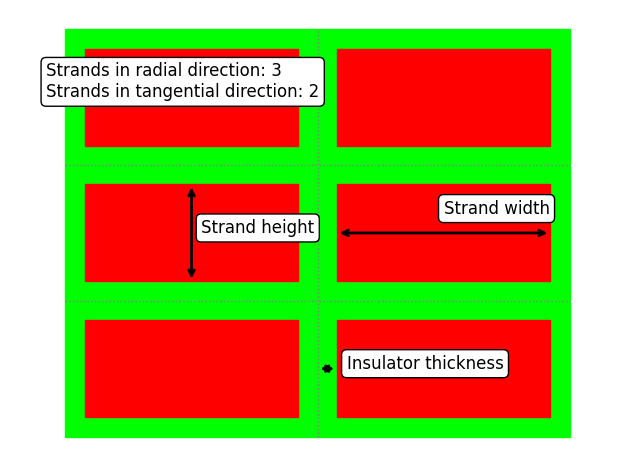

In [6]:
from pyleecan.Classes.CondType11 import CondType11

# Conductor setup
stator.winding.conductor = CondType11(
    Nwppc_tan=1, # stator winding number of preformed wires (strands) 
                 # in parallel per coil along tangential (horizontal) direction
    Nwppc_rad=10, # stator winding number of preformed wires (strands) 
                 # in parallel per coil along radial (vertical) direction
    Wwire=6 * mm, #  single wire width without insulation [m]
    Hwire=13 * mm, # single wire height without insulation [m]
    Wins_wire=0.3 * mm, # winding strand insulation thickness [m]
    type_winding_shape=0, # type of winding shape for end winding length calculation
                          # 0 for hairpin windings
                          # 1 for normal windings
    alpha_ew=None,
)

fig, ax = stator.winding.conductor.plot_schematics(is_default=True, is_single=True, is_show_fig=False)
fig, ax = stator.winding.conductor.plot_schematics(is_default=True, is_single=False, is_show_fig=False)

## Rotor definition

In [7]:
from pyleecan.Classes.LamSlotMag import LamSlotMag

# Rotor setup
rotor = LamSlotMag(
    Rint=141 * mm, # Internal radius
    Rext=150 * mm, # external radius
    is_internal=False,
    is_stator=False,
    Kf1=stator.Kf1, # Lamination stacking / packing factor
    L1=stator.L1 # Lamination stack active length [m] 
                 # without radial ventilation airducts but including insulation layers between lamination sheets
)

### Magnet definition

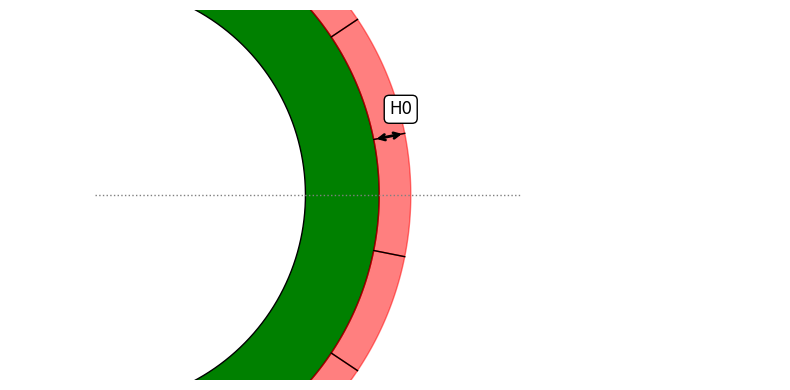

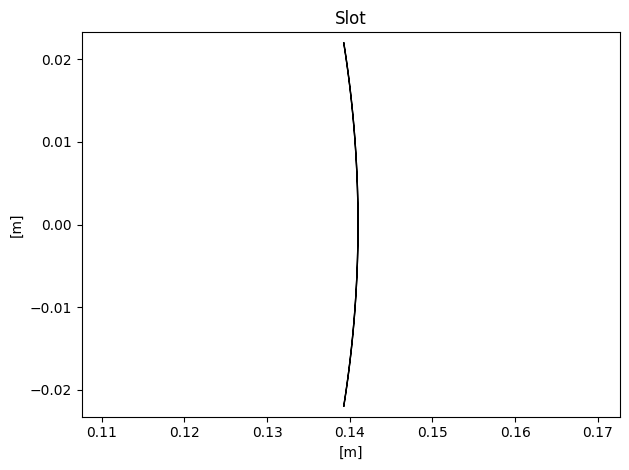

In [8]:
from pyleecan.Classes.SlotM18 import SlotM18
from pyleecan.Classes.Magnet import Magnet

# Magnet setup
Zs = 20
H0 = 10 * mm
rotor.slot = SlotM18(
    H0,  # for some reason passed as args, not kwargs - see https://www.pyleecan.org/_modules/pyleecan/Classes/SlotM18.html#SlotM18
    Zs,  # for some reason passed as args, not kwargs - see https://www.pyleecan.org/_modules/pyleecan/Classes/SlotM18.html#SlotM18
)
rotor.magnet = Magnet(
    Lmag=rotor.L1,
)

fig, ax = rotor.slot.plot_schematics(is_default=True, is_show_fig=False)
fig, ax = rotor.slot.plot(is_show_fig=False)

## Set materials

In [9]:
from os.path import join
from pyleecan.Classes.Material import Material
from pyleecan.Classes.MatMagnetics import MatMagnetics
from pyleecan.Classes.MatHT import MatHT
from pyleecan.definitions import DATA_DIR
from pyleecan.Functions.load import load

# Loading Materials 
M400_50A = load(join(DATA_DIR, "Material", "M400-50A.json"))
Copper1 = load(join(DATA_DIR, "Material", "Copper1.json"))
Magnet_prius = load(join("C:/Users/nmb48/AppData/Roaming/pyleecan/Material/MagnetPrius.json"))
INSULATOR1 = load(join("C:/Users/nmb48/AppData/Roaming/pyleecan/Material/INSULATOR1.json"))

# Set Materials
stator.mat_type = M400_50A  # Stator Lamination material
rotor.mat_type = M400_50A  # Rotor Lamination material
rotor.magnet.mat_type = Magnet_prius
rotor.magnet.type_magnetization = 0
stator.winding.conductor.ins_mat = INSULATOR1
stator.winding.conductor.cond_mat = Copper1  # Stator winding conductor material

## Create, save and plot the machine

[00:19:05] Saving MachineSIPMSM to file 'detailed_demonstrator_ch5_scripted.json'.
Saving MachineSIPMSM to file 'detailed_demonstrator_ch5_scripted.json'.


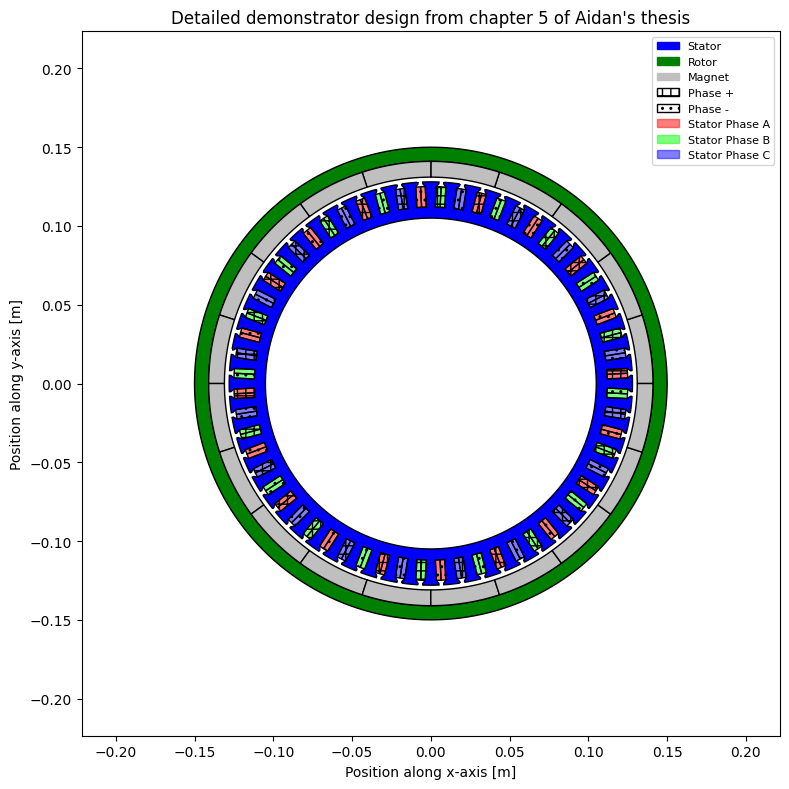

In [10]:
from pyleecan.Classes.MachineSIPMSM import MachineSIPMSM

detailed_demonstrator_ch5_scripted = MachineSIPMSM(
    name="Detailed demonstrator design from chapter 5 of Aidan's thesis",
    stator=stator,
    rotor=rotor,
    shaft=None,
    frame=None
)
detailed_demonstrator_ch5_scripted.save('detailed_demonstrator_ch5_scripted.json')

fig, ax = detailed_demonstrator_ch5_scripted.plot(is_show_fig=False)

## Manually edit .json file to add Hmag

Comparing https://www.pyleecan.org/_modules/pyleecan/Classes/SlotM18.html#SlotM18 and https://github.com/NilsBarner/pyleecan/blob/master/pyleecan/Classes/SlotM18.py, it became clear that Hmag was renamed to H0 at some point but the documentation did no get updated. When loading the .json file of the present machine into the GUI and plotting the machine cross-section, the GUI would only recognise Hmag but not H0 https://www.pyleecan.org/pyleecan.GUI.Dialog.DMachineSetup.SMSlot.PMSlot18.PMSlot18.html?highlight=slotm18, hence I had to manually add this to the json.

In [11]:
import json

# Load the JSON file
with open("detailed_demonstrator_ch5_scripted.json", "r") as f:
    machine = json.load(f)

machine["rotor"]["slot"]["Hmag"] = rotor.slot.H0

# Save the updated JSON
with open("detailed_demonstrator_ch5_scripted.json", "w") as f:
    json.dump(machine, f, indent=2)

Upon comparison between the json file created by this Jupyter Notebook and that created by inserting the same values into the GUI in a tool like diffchecker, I confirm that I successfully scripted the detailed machine demonstrator design from chapter 5 of Aidan's thesis.